# PROBLEM STATEMENT

- The objective is to develop a predictive model that estimates the insurance premium a customer should pay based on their personal characteristics and risk-related factors. The model should account for diverse risk profiles and accurately determine appropriate premium amounts tailored to each customer's unique situation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
stats.chisqrob = lambda chisq, df:stats.chi2.sf(chisq, df)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score



import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots


import shap
import lime
shap.initjs()
sns.set()

C:\Users\ntabi\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DATA LOADING

In [2]:
data= pd.read_excel('Data1.xlsx')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,Gauteng,16884.92
1,18,male,33.770,1,no,Western Cape,1725.55
2,28,male,33.000,3,no,Western Cape,4449.46
3,33,male,22.705,0,no,KZN,21984.47
4,32,male,28.880,0,no,KZN,3866.86


# DATA PREPARATION
- cleaning
- handing outliers

In [3]:
data.shape

(1338, 7)

In [4]:
data.duplicated(). sum()

1

In [5]:
data.drop_duplicates(inplace=True)

In [6]:
data.duplicated().sum()

0

In [7]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [8]:
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [9]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [10]:
# Check for negative ages 
print(data[data['age'] < 0])
print(data[data['charges'] < 0])
print(data[data['bmi'] < 0])





Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []
Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []
Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []


In [11]:
print(data.value_counts())


age  sex     bmi     children  smoker  region        charges 
18   female  20.790  0         no      Western Cape  1607.51     1
48   female  27.360  1         no      North-West    9447.38     1
             25.850  3         yes     Western Cape  24180.93    1
             22.800  0         no      Gauteng       8269.04     1
47   male    47.520  1         no      Western Cape  8083.92     1
                                                                ..
31   female  25.740  0         no      Western Cape  3756.62     1
             23.600  2         no      Gauteng       4931.65     1
             21.755  0         no      KZN           4134.08     1
30   male    44.220  2         no      Western Cape  4266.17     1
64   male    40.480  0         no      Western Cape  13831.12    1
Name: count, Length: 1337, dtype: int64


In [12]:
data.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121638
std,14.044333,6.100468,1.205571,12110.359657
min,18.000000,15.960000,0.000000,1121.870000
25%,27.000000,26.290000,0.000000,4746.340000
50%,39.000000,30.400000,1.000000,9386.160000
75%,51.000000,34.700000,2.000000,16657.720000
max,64.000000,53.130000,5.000000,63770.430000


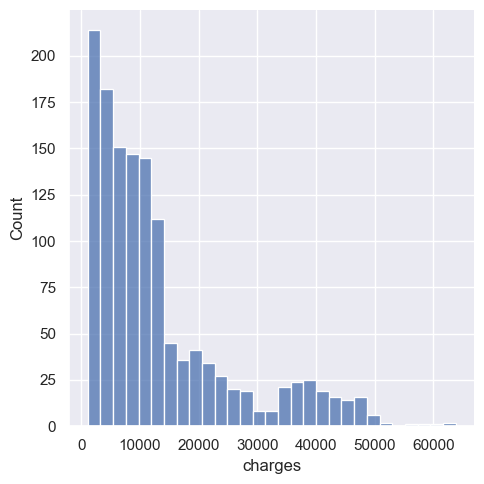

In [13]:
sns.displot(data['charges'])

<Axes: ylabel='charges'>

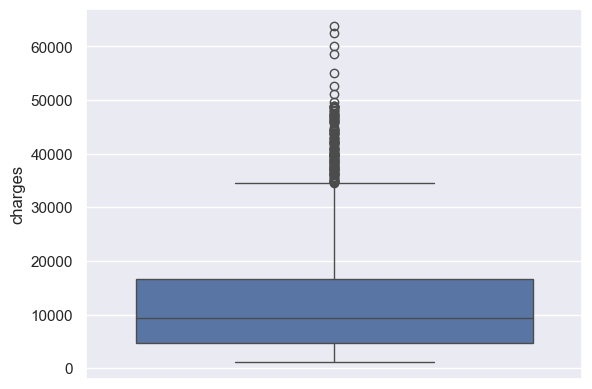

In [14]:
sns.boxplot(data['charges'])

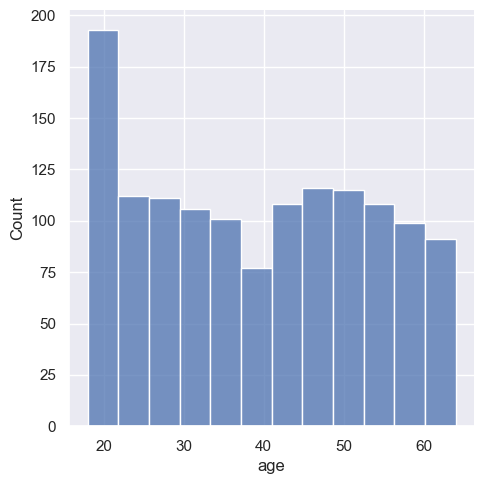

In [15]:
sns.displot(data['age'])

<Axes: ylabel='age'>

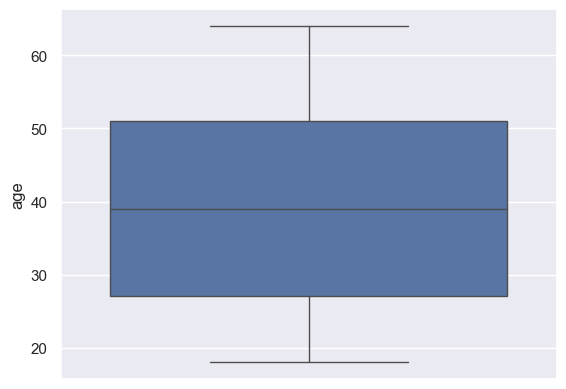

In [16]:
sns.boxplot(data['age'])

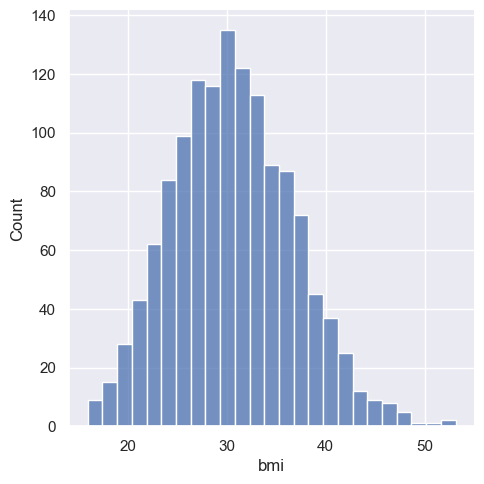

In [17]:
sns.displot(data['bmi'])

<Axes: ylabel='bmi'>

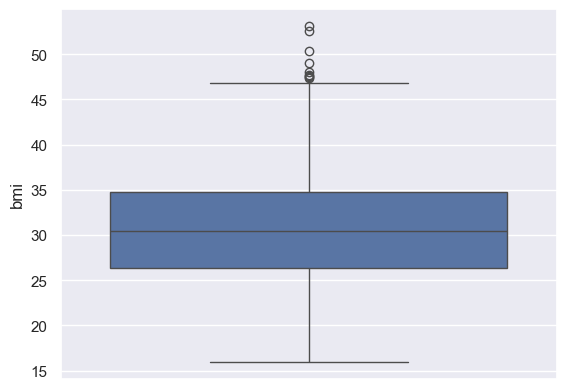

In [18]:
sns.boxplot(data['bmi'])

### Handling outliers

In [19]:
# for charges
upper_limit = data['charges'].mean()+ 3*data['charges'].std()
lower_limit = data['charges'].mean()- 3*data['charges'].std() 

print(upper_limit," " ,lower_limit)

49610.200609060106   -23051.95733306908


In [20]:
# applying capping
data['charges'] = np.where(data['charges'] < lower_limit, lower_limit, data['charges'])
data['charges'] = np.where(data['charges'] > upper_limit, upper_limit, data['charges'])

In [21]:
# for bmi
upper_limit = data['bmi'].mean()+ 3*data['bmi'].std()
lower_limit = data['bmi'].mean()- 3*data['bmi'].std() 

print(upper_limit," " ,lower_limit)

48.96485698651382   12.362046528819015


In [22]:
# applying capping
data['bmi'] = np.where(data['bmi'] < lower_limit, lower_limit, data['bmi'])
data['bmi'] = np.where(data['bmi'] > upper_limit, upper_limit, data['bmi'])


<Axes: ylabel='charges'>

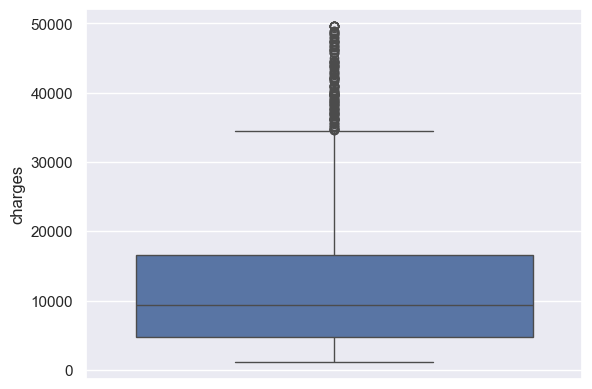

In [23]:
sns.boxplot(data['charges'])

<Axes: ylabel='bmi'>

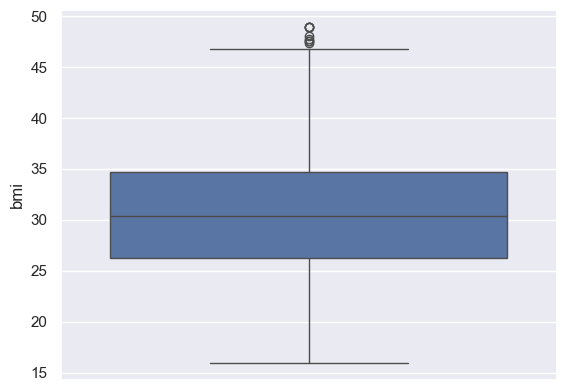

In [24]:
sns.boxplot(data['bmi'])

In [25]:
""" ""
Define the lower and upper percentiles
lower_percentile = data['bmi'].quantile(0.01)
upper_percentile = data['bmi'].quantile(0.99)

# Filter out outliers
data['bmi']= data[(data['bmi'] > lower_percentile) | (data['bmi'] < upper_percentile)]

# Display outliers
print(data['bmi'])

"""""

' ""\nDefine the lower and upper percentiles\nlower_percentile = data[\'bmi\'].quantile(0.01)\nupper_percentile = data[\'bmi\'].quantile(0.99)\n\n# Filter out outliers\ndata[\'bmi\']= data[(data[\'bmi\'] > lower_percentile) | (data[\'bmi\'] < upper_percentile)]\n\n# Display outliers\nprint(data[\'bmi\'])\n\n'

# EDA AND VISUALISATION

In [26]:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

<Axes: xlabel='age', ylabel='Count'>

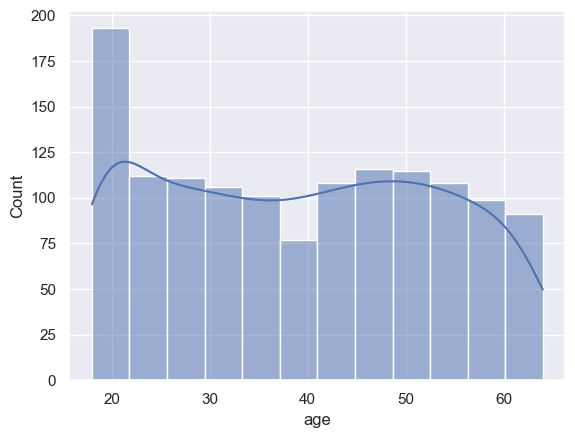

In [27]:
sns.histplot(data=data, x='age', kde=True)


<Axes: xlabel='age', ylabel='Density'>

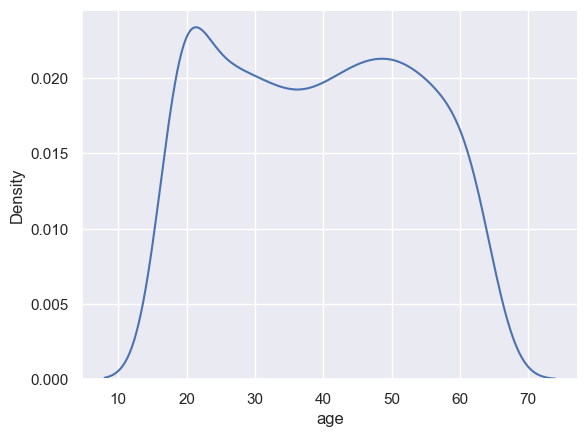

In [28]:
sns.kdeplot(data=data, x='age')


<Axes: xlabel='sex', ylabel='count'>

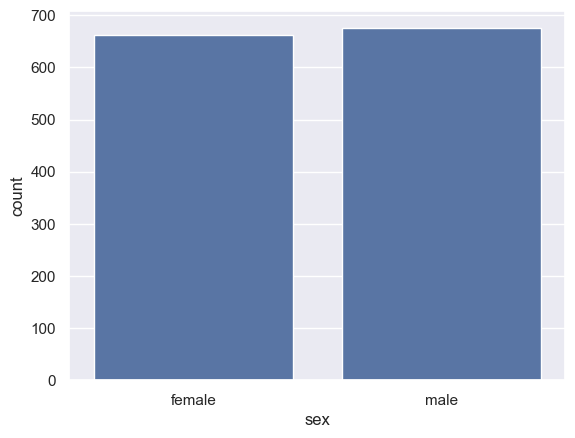

In [29]:
sns.countplot(data=data, x='sex')


<Axes: xlabel='charges', ylabel='Count'>

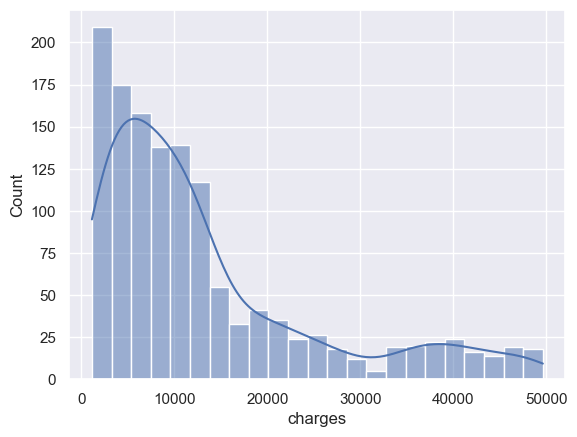

In [30]:
sns.histplot(data=data, x='charges', kde=True)


<Axes: xlabel='age', ylabel='charges'>

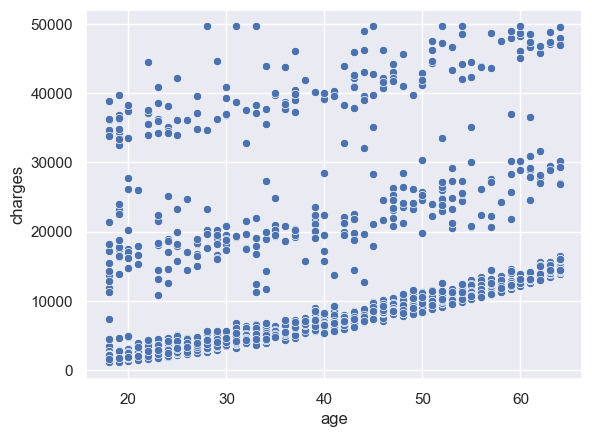

In [31]:
sns.scatterplot(data=data, x='age', y='charges')


<Axes: xlabel='bmi', ylabel='charges'>

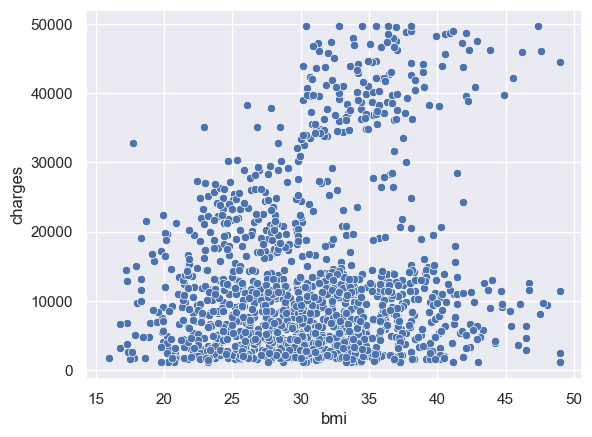

In [32]:
sns.scatterplot(data=data, x='bmi', y='charges')


<Axes: xlabel='smoker', ylabel='charges'>

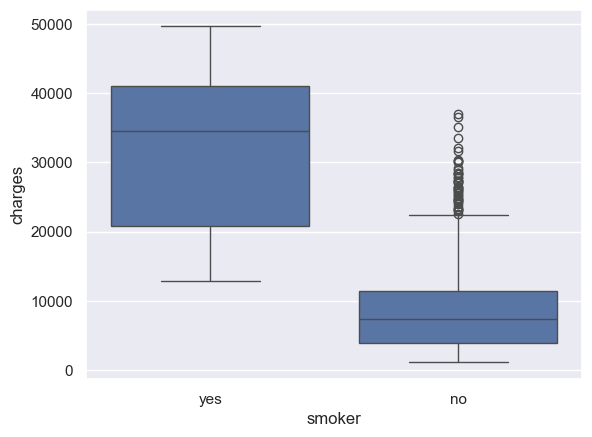

In [33]:
sns.boxplot(data=data, x='smoker', y='charges')


<Axes: xlabel='region', ylabel='charges'>

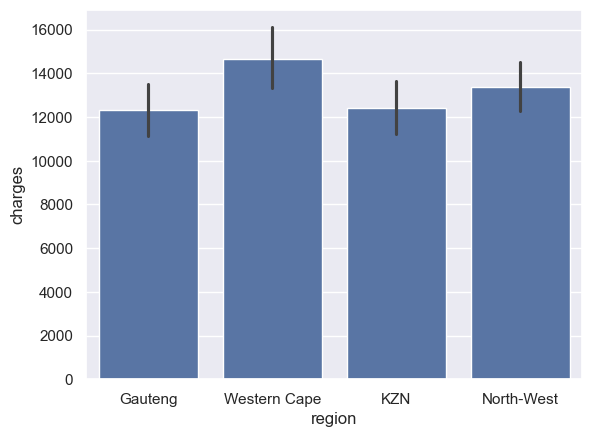

In [34]:
sns.barplot(data=data, x='region', y='charges')


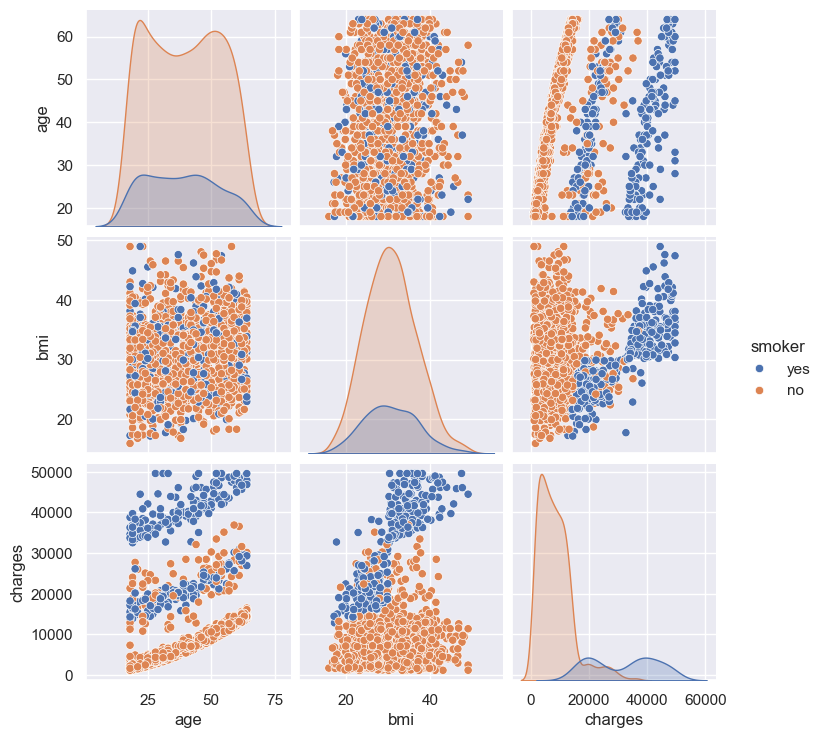

In [35]:
sns.pairplot(data=data, vars=['age', 'bmi', 'charges'], hue='smoker')


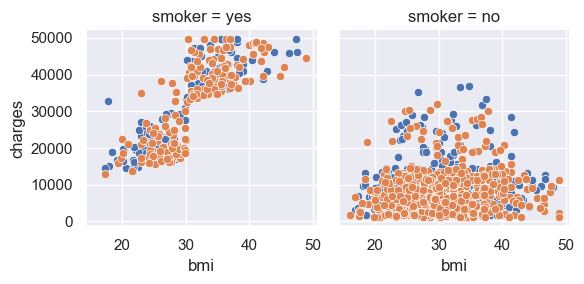

In [36]:
g = sns.FacetGrid(data, col='smoker', hue='sex')
g.map(sns.scatterplot, 'bmi', 'charges')


### EDA SUMNARY ALAYSIS
**Insights**

Exploratory Data Analysis (EDA) provides valuable insights into the dataset before fitting it to a predictive model. Key observations include:

1. **Age Distribution**: The dataset primarily consists of individuals around 20 years old, suggesting younger individuals may influence premium charges due to higher perceived risk.
2. **Premium Charges**: The distribution of premium charges is skewed, with most individuals having lower premiums, but some facing significantly higher charges. Factors like **BMI**, **age**, and **smoking** contribute to higher premiums.
3. **Impact of BMI, Age, and Smoking**: Higher **BMI**, older **age**, and **smoking** are positively correlated with higher premium charges due to associated health risks.
4. **Geographic Analysis**: The **Western Cape** has the highest premium charges, likely due to regional factors such as population density and healthcare access.


# MODEL SELECTION
1. STATS MODEL
2. LINEAR REGRESSION

# FEATURES ENGINEERING
- involve feature removed or added
- dummy varuable or one hor endoing
- scaling and transformation

In [37]:
dummies = pd.get_dummies(data, columns=['sex', 'smoker', 'region'])
dummies = dummies.astype(int)
data1 = dummies


In [38]:
data1

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_Gauteng,region_KZN,region_North-West,region_Western Cape
0,19,27,0,16884,1,0,0,1,1,0,0,0
1,18,33,1,1725,0,1,1,0,0,0,0,1
2,28,33,3,4449,0,1,1,0,0,0,0,1
3,33,22,0,21984,0,1,1,0,0,1,0,0
4,32,28,0,3866,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30,3,10600,0,1,1,0,0,1,0,0
1334,18,31,0,2205,1,0,1,0,0,0,1,0
1335,18,36,0,1629,1,0,1,0,0,0,0,1
1336,21,25,0,2007,1,0,1,0,1,0,0,0


## STATS MODEL

### Defining the input and output variables

In [39]:
X= data1.drop(columns=['charges'])
Y= data1['charges']

In [40]:
x=sm.add_constant(X)
model= sm.OLS(Y,x).fit()

In [41]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     514.2
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:42:43   Log-Likelihood:                -13508.
No. Observations:                1337   AIC:                         2.703e+04
Df Residuals:                    1328   BIC:                         2.708e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -153.5277    416.034     -0.369      0.712    -969.684     662.629
age                   255.4015     11.647     21.929      0.000     232.554     278.249
bmi                   332.2894     28.016     11.861      0.000     277.329     387.250
children              488.2762    134.798      3.622      0.000     223.836     752.716
sex_female            -22.6571    261.458     -0.087      0.931    -535.572     490.258
sex_male             -130.8706    266.874     -0.490      0.624    -654.411     392.670
smoker_no            -1.19e+04    274.569    -43.348      0.000   -1.24e+04   -1.14e+04
smoker_yes           1.175e+04    304.622     38.568      0.000    1.12e+04    1.23e+04
region_Gauteng       -399.7113    303.868     -1.315      0.189    -995.824     196.401
region_KZN            183.4466    294.736      0.622      0.534    -394.752     761.645
region_North-West     554.4947    293.441      1.890      0.059     -21.164    1130.153
region_Western Cape  -491.7576    322.771     -1.524      0.128   -1124.954     141.438
==============================================================================
Omnibus:                      254.324   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              510.115
Skew:                           1.108   Prob(JB):                    1.70e-111
Kurtosis:                       5.061   Cond. No.                     5.06e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.36e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [42]:
# Get the predicted values
yhat = model.predict(x)

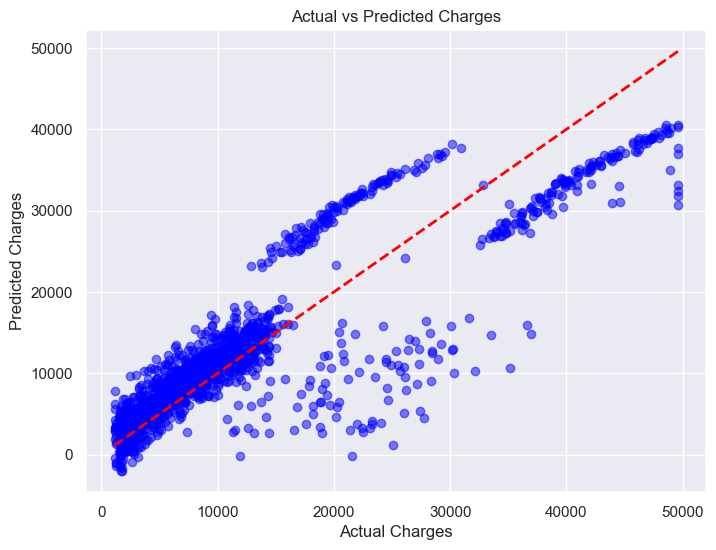

In [43]:
plt.figure(figsize=(8, 6))
plt.scatter(Y, yhat, color='blue', alpha=0.5)
plt.plot([min(Y), max(Y)], [min(Y), max(Y)], color='red', linestyle='--', lw=2)  # Add a reference line (y = x)
plt.title('Actual vs Predicted Charges')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.grid(True)
plt.show()

**INTERPRETATION**

### **yhat = intercept + age.x1 +  sex.x2+  bmi.x3+  children.x4 +  smoker.x5 +  region.x6**

**significant level= 0.05 default**

**Null Hypothesis (H₀)**: There is no significant relationship between the dependent variable (charges) and the independent variables (age, region, etc.).

**Alternative Hypothesis (H₁)**: There is a significant relationship between the dependent variable (charges) and the independent variables (age, region, etc.).

At a 95% confidence level, we fail to reject the null hypothesis for both age and region. This is because the p-values associated with these variables are greater than 0.05. Since the p-values exceed the significance level of 0.05, we conclude that there is insufficient evidence to suggest a significant relationship between age and charges, as well as between region and charges. Therefore, age and region do not have a statistically significant effect on the premium charges in this analysis.


**R² (Coefficient of Determination)**:
R² tells us the proportion of the total variation in the dependent variable (charges) that is explained by the independent variables (such as age, region, etc.) in the model. In this case, the R² value of 76% indicates that 76% of the total variation in charges can be explained by the independent variables included in the model.

**Adjusted R²**:
Adjusted R² adjusts the R² value to account for the number of predictors in the model, providing a more accurate measure when comparing models with different numbers of predictors. In our case, the Adjusted R² is also 75%, which suggests that, after accounting for the number of predictors, the model still explains 75% of the variation in charges.

While R² indicates the overall fit of the model, Adjusted R² helps ensure that the model's explanatory power isn't artificially inflated by the inclusion of too many predictors.

**Interpretation of the coefficients**
1. Age- keep constant other indipendent variables, them age increase by 1 year, the charges is expected to increase by 255 units
2.BMI- keep constant other indipendent variables, when bmi increase by 1 unit, the charges is expected to increase by 332 units
3. Children- keep constant other indipendent variables, when children increase by 1, the charges is expected to increase by 488 units
4. Smoker- keep constant other indipendent variables, when smoker is yes, the charges is expected to increase by 2236 units 1.17.2x10^04 units
5. Smoker- keep constant other indipendent variables, when is not yes, the charges is expected to decrease by -1.19x10^04 units
5. Region- keep constant other indipendent variables, when region changes, the charges is expected to increase by 1019 units for each region (as the coefficient for each region is the same)....


## LINEAR REGRESSION

### MODEL SELECTION: Regression assumption
1. Linearity - The relationship between the independent variable(s) (X) and the dependent variable (Y) must be linear.
2. no multicolliarity - Independent variables (predictors) should not be highly correlated with each other.
3. normality of Residuals and Homoscedasticity:  The residuals (errors) should follow a normal distribution,and residuals should have a mean of zero and equal variance across all levels of the predictors.
4. Indipendence fo errors ( no endogeneity e and x)
5. no autocorrelation between residuals

#### Linearity assumption

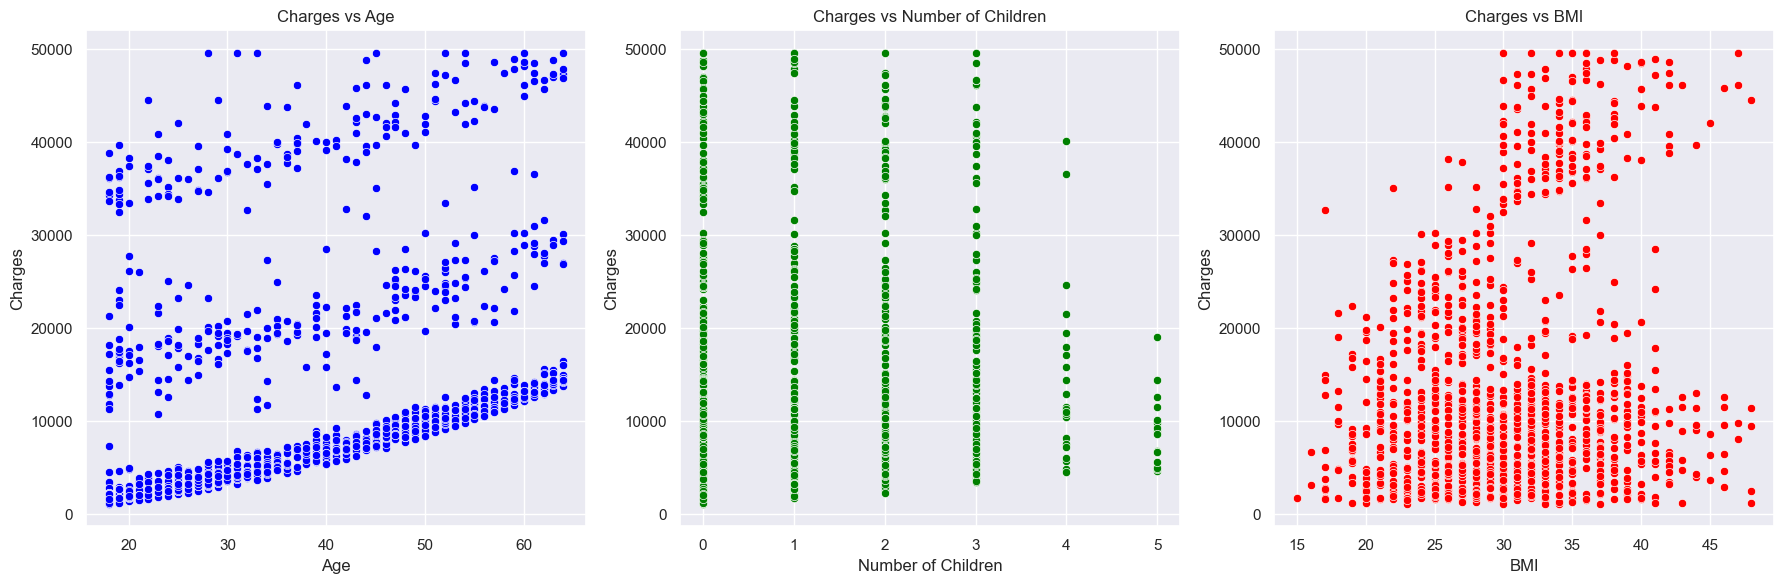

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Charges vs Age
sns.scatterplot(data=data1, x='age', y='charges', ax=axes[0], color='blue')
axes[0].set_title('Charges vs Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Charges')

# Plot 2: Charges vs Number of Children
sns.scatterplot(data=data1, x='children', y='charges', ax=axes[1], color='green')
axes[1].set_title('Charges vs Number of Children')
axes[1].set_xlabel('Number of Children')
axes[1].set_ylabel('Charges')

# Plot 3: Charges vs BMI
sns.scatterplot(data=data1, x='bmi', y='charges', ax=axes[2], color='red')
axes[2].set_title('Charges vs BMI')
axes[2].set_xlabel('BMI')
axes[2].set_ylabel('Charges')


plt.tight_layout()
plt.show()


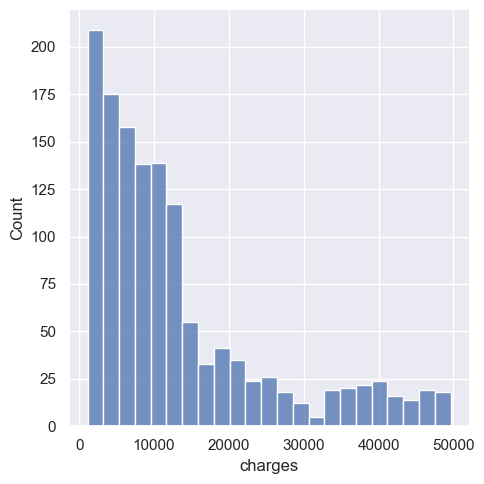

In [45]:
sns.displot(data1['charges'])

In [46]:
log_children= np.log(data1['charges'])
data1['log_charges']= log_children
data1

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_Gauteng,region_KZN,region_North-West,region_Western Cape,log_charges
0,19,27,0,16884,1,0,0,1,1,0,0,0,9.734122
1,18,33,1,1725,0,1,1,0,0,0,0,1,7.452982
2,28,33,3,4449,0,1,1,0,0,0,0,1,8.400435
3,33,22,0,21984,0,1,1,0,0,1,0,0,9.998070
4,32,28,0,3866,0,1,1,0,0,1,0,0,8.259976
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30,3,10600,0,1,1,0,0,1,0,0,9.268609
1334,18,31,0,2205,1,0,1,0,0,0,1,0,7.698483
1335,18,36,0,1629,1,0,1,0,0,0,0,1,7.395722
1336,21,25,0,2007,1,0,1,0,1,0,0,0,7.604396


<Axes: xlabel='log_charges', ylabel='Count'>

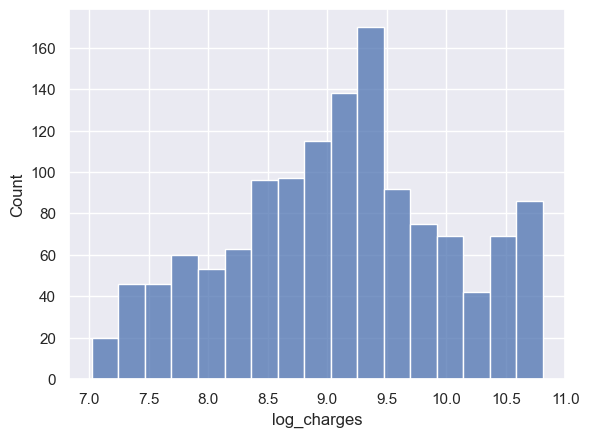

In [47]:
sns.histplot(data1['log_charges'])

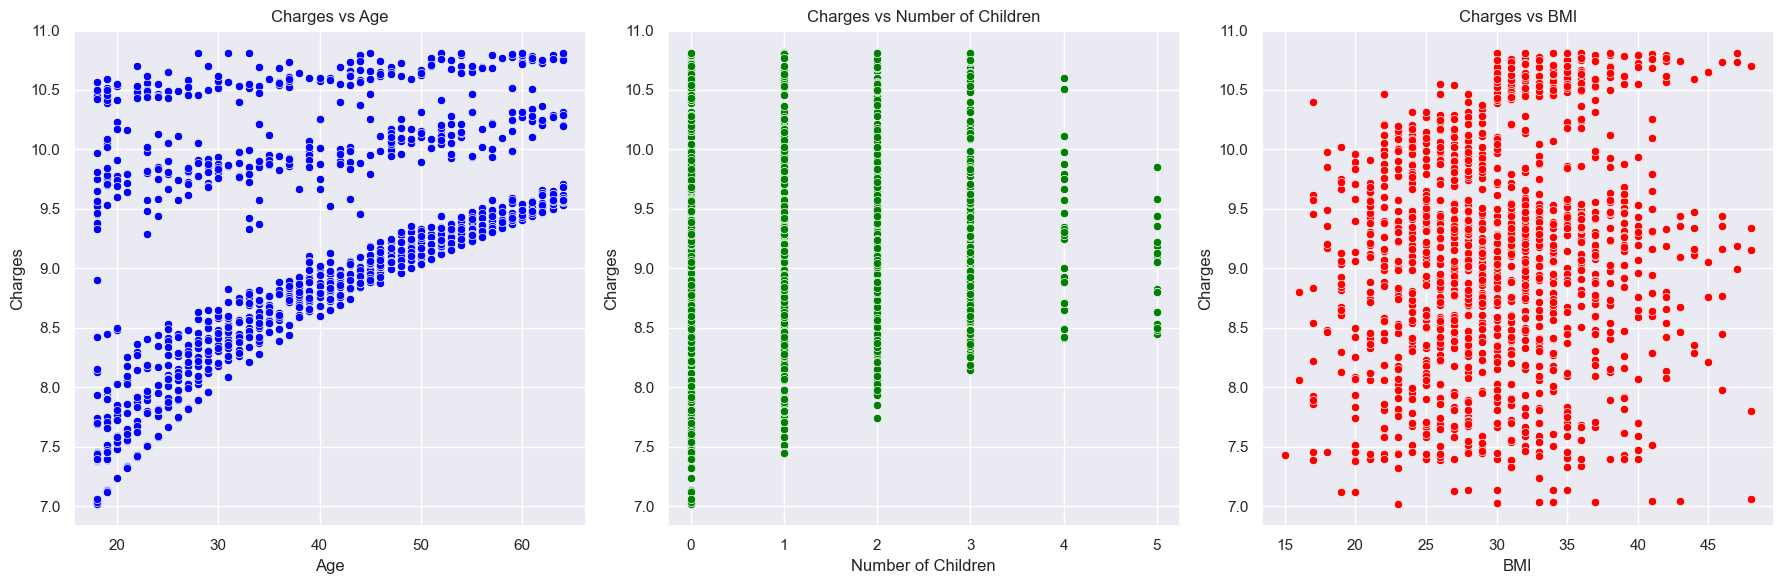

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Charges vs Age
sns.scatterplot(data=data1, x='age', y='log_charges', ax=axes[0], color='blue')
axes[0].set_title('Charges vs Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Charges')

# Plot 2: Charges vs Number of Children
sns.scatterplot(data=data1, x='children', y='log_charges', ax=axes[1], color='green')
axes[1].set_title('Charges vs Number of Children')
axes[1].set_xlabel('Number of Children')
axes[1].set_ylabel('Charges')

# Plot 3: Charges vs BMI
sns.scatterplot(data=data1, x='bmi', y='log_charges', ax=axes[2], color='red')
axes[2].set_title('Charges vs BMI')
axes[2].set_xlabel('BMI')
axes[2].set_ylabel('Charges')


plt.tight_layout()
plt.show()


#### No Multicollinearity assumption

- using vif from the stats models and heatmap
- if vif= 1 no multicollinearity
- if vif >10 : its high then we have to drop one
- if vif betweem 1< VIF >5 moderate

In [49]:
data1.columns

Index(['age', 'bmi', 'children', 'charges', 'sex_female', 'sex_male',
       'smoker_no', 'smoker_yes', 'region_Gauteng', 'region_KZN',
       'region_North-West', 'region_Western Cape', 'log_charges'],
      dtype='object')

#### Checking using VIF

In [50]:

X = sm.add_constant(data1[['age', 'children', 'bmi']]) 

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

    Feature        VIF
0     const  31.204043
1       age   1.014058
2  children   1.001782
3       bmi   1.012451


####  Checking using Heatmap sns

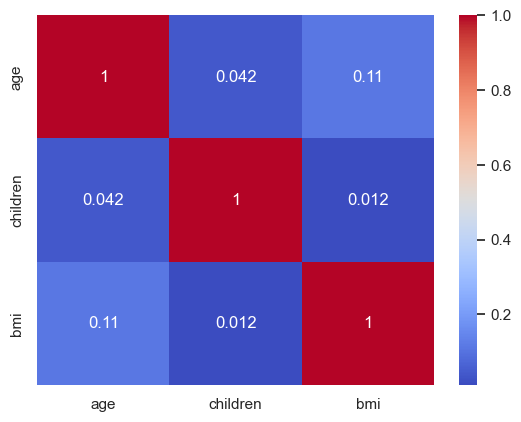

In [51]:
correlation_matrix = data1[['age', 'children', 'bmi']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [52]:
data1
data1 = data1.drop('charges', axis=1)

In [53]:
input= data1.drop('log_charges', axis=1)
target=data1['log_charges']

In [54]:
input
target

0        9.734122
1        7.452982
2        8.400435
3        9.998070
4        8.259976
          ...    
1333     9.268609
1334     7.698483
1335     7.395722
1336     7.604396
1337    10.279901
Name: log_charges, Length: 1337, dtype: float64

### Scaling and transformation

In [55]:
scaler= StandardScaler()
scaler.fit(input)
scaled_data = scaler.transform(input)

In [56]:
scaled_data

array([[-1.44041773, -0.5189447 , -0.90923416, ..., -0.5655458 ,
        -0.5655458 , -0.61163774],
       [-1.51164747,  0.46614153, -0.07944162, ..., -0.5655458 ,
        -0.5655458 ,  1.63495472],
       [-0.79935006,  0.46614153,  1.58014347, ..., -0.5655458 ,
        -0.5655458 ,  1.63495472],
       ...,
       [-1.51164747,  0.95868464, -0.90923416, ..., -0.5655458 ,
        -0.5655458 ,  1.63495472],
       [-1.29795825, -0.84730678, -0.90923416, ..., -0.5655458 ,
        -0.5655458 , -0.61163774],
       [ 1.55123139, -0.19058263, -0.90923416, ...,  1.76820338,
        -0.5655458 , -0.61163774]])

# TRAINING AND TESTING

In [57]:
x_train, x_test, y_train, y_test = train_test_split(scaled_data, target, test_size=0.2, random_state=42)

print(f"Train size: {x_train.shape}, Test size: {x_test.shape}")

Train size: (1069, 11), Test size: (268, 11)


In [58]:
model= LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [59]:
predictions = model.predict(x_test)


#### Evaluation

In [60]:
model.score(x_train, y_train)

0.7499794312656869

In [61]:
model.score(x_test, y_test)

0.8278329874340783

In [62]:
intercepts = model.intercept_
print(f"Intercepts: {intercepts}")

Intercepts: 9.106893656590263


In [63]:
df_pf = pd.DataFrame(np.exp(predictions), columns=['Prediction'])
df_pf.head()

,Prediction
0,7604.409081
1,5844.754706
2,13722.821538
3,28966.227000
4,5490.638920


In [64]:
df_pf['target'] =np.exp(y_test)
df_pf

,Prediction,target
0,7604.409081,NaN
1,5844.754706,NaN
2,13722.821538,NaN
3,28966.227000,NaN
4,5490.638920,NaN
...,...,...
263,14241.633730,NaN
264,14103.232164,NaN
265,4696.392344,46151.0
266,64452.934039,NaN


In [65]:
y_test = y_test.reset_index(drop=True)
y_test.head

<bound method NDFrame.head of 0       9.069698
1       8.649624
2       9.344522
3      10.564783
4       8.403576
         ...    
263     9.534668
264     9.538708
265     8.275122
266    10.766441
267     9.051813
Name: log_charges, Length: 268, dtype: float64>

In [66]:
df_pf['target'] =np.exp(y_test)
df_pf

,Prediction,target
0,7604.409081,8688.0
1,5844.754706,5708.0
2,13722.821538,11436.0
3,28966.227000,38746.0
4,5490.638920,4463.0
...,...,...
263,14241.633730,13831.0
264,14103.232164,13887.0
265,4696.392344,3925.0
266,64452.934039,47403.0


In [67]:
df_pf['Residuals'] = df_pf['target']-df_pf['Prediction']
df_pf

,Prediction,target,Residuals
0,7604.409081,8688.0,1083.590919
1,5844.754706,5708.0,-136.754706
2,13722.821538,11436.0,-2286.821538
3,28966.227000,38746.0,9779.773000
4,5490.638920,4463.0,-1027.638920
...,...,...,...
263,14241.633730,13831.0,-410.633730
264,14103.232164,13887.0,-216.232164
265,4696.392344,3925.0,-771.392344
266,64452.934039,47403.0,-17049.934039


In [68]:
df_pf['Difference%'] = np.absolute(df_pf['Residuals']/df_pf['target']*100)
df_pf

,Prediction,target,Residuals,Difference%
0,7604.409081,8688.0,1083.590919,12.472271
1,5844.754706,5708.0,-136.754706,2.395843
2,13722.821538,11436.0,-2286.821538,19.996691
3,28966.227000,38746.0,9779.773000,25.240729
4,5490.638920,4463.0,-1027.638920,23.025743
...,...,...,...,...
263,14241.633730,13831.0,-410.633730,2.968937
264,14103.232164,13887.0,-216.232164,1.557083
265,4696.392344,3925.0,-771.392344,19.653308
266,64452.934039,47403.0,-17049.934039,35.968049


In [69]:
predictions = np.exp(predictions)


In [70]:
predictions

array([ 7604.40908135,  5844.75470619, 13722.82153795, 28966.2269996 ,
        5490.63891993,  9995.80716288, 23150.34009512,  3073.9596002 ,
        7769.55270935, 10635.28705801, 11714.8483579 , 40097.9767372 ,
       25301.82832311, 15189.77877446,  7724.16109954,  7973.24452839,
        3304.32470648, 26245.58416519,  3908.68452046,  4448.62655342,
        3131.52839383, 27105.16540594, 11561.41815928, 27291.0893809 ,
       25301.82832311,  4299.14308963, 41109.04709968, 53433.35907008,
       10113.63457464, 12992.50629757,  5033.5754926 ,  9371.86950249,
        2606.28918147, 11488.2626796 , 55833.86389272, 10419.40181834,
        4789.02038321,  5332.11384097, 34617.28837734,  7826.66751834,
        4130.40993063, 36831.92293165, 40570.63899835, 10287.96036672,
        8331.44420506,  3810.68991428,  3653.98394857,  7402.90693856,
        4435.61254062,  6642.40645072,  5006.61216284,  7095.0140002 ,
       35698.72379503,  2896.19031859,  7926.66290161,  7667.79432725,
      

In [71]:
target= np.exp(y_test)
target

0       8688.0
1       5708.0
2      11436.0
3      38746.0
4       4463.0
        ...   
263    13831.0
264    13887.0
265     3925.0
266    47403.0
267     8534.0
Name: log_charges, Length: 268, dtype: float64

In [72]:
residuals= target-predictions
residuals

0       1083.590919
1       -136.754706
2      -2286.821538
3       9779.773000
4      -1027.638920
           ...     
263     -410.633730
264     -216.232164
265     -771.392344
266   -17049.934039
267      638.240228
Name: log_charges, Length: 268, dtype: float64

In [73]:
coefficients = model.coef_
print(f"Coefficients for each output: {coefficients}")

Coefficients for each output: [ 4.77954285e-01  8.25593380e-02  1.18740079e-01  8.60548262e+11
  8.60548262e+11  6.35882109e+10  6.35882109e+10 -6.18671226e+12
 -6.18023812e+12 -6.18023812e+12 -6.42000096e+12]


In [74]:
mse = mean_squared_error(target, predictions)  # Mean Squared Error
r2 = r2_score(target, predictions)  # R-squared score

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 51181206.8610257
R-squared Score: 0.7053784379201586


### Checking residuals assumptions

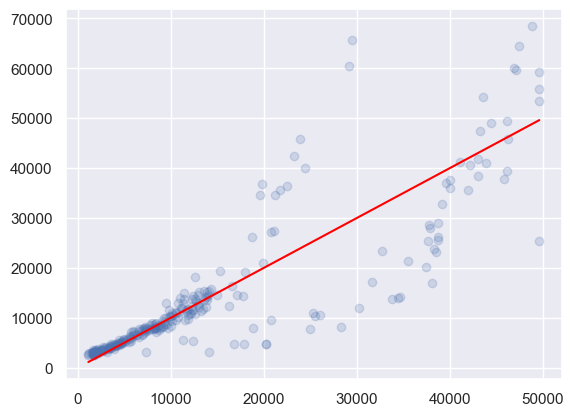

In [75]:
plt.scatter(target,predictions, alpha=0.2)
plt.plot([min(target), max(target)], [min(target), max(target)], color='red')
plt.show()

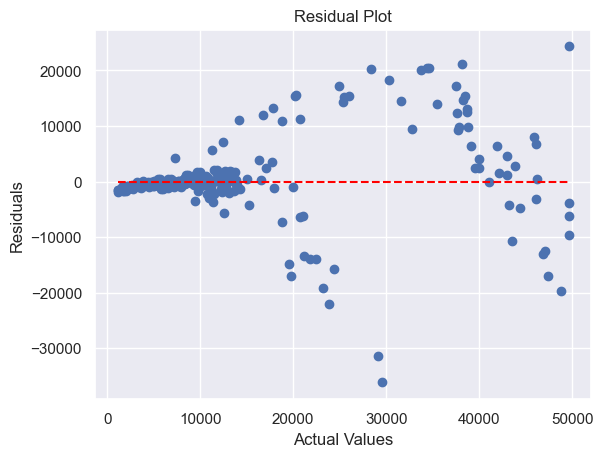

In [76]:
plt.scatter(target, residuals)
plt.hlines(0, min(target), max(target), colors='red', linestyles='dashed')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


In [ ]:
dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson Statistic: {dw_stat}')

"""
A Durbin-Watson statistic close to 2 indicates no autocorrelation.
Values below 2.0 mean there is positive autocorrelation and above 2.0 indicate negative autocorrelation
"""

Durbin-Watson Statistic: 2.0663575743229887


'\nA Durbin-Watson statistic close to 2 indicates no autocorrelation.\nValues below 1.5 suggest positive autocorrelation, and values above 2.5 suggest negative autocorrelation.\n\n'

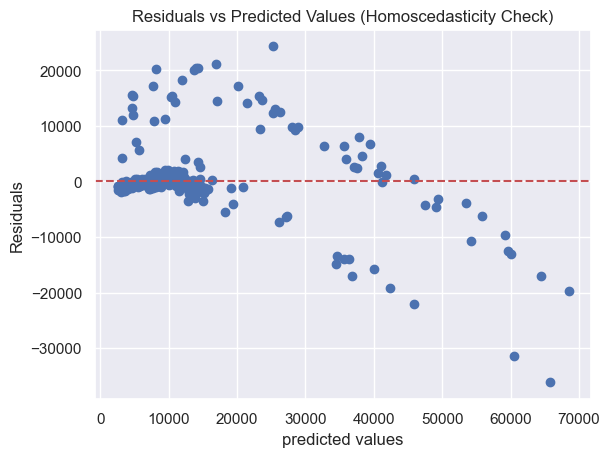

In [78]:
plt.scatter(predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--') 
plt.xlabel('predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (Homoscedasticity Check)')
plt.show()

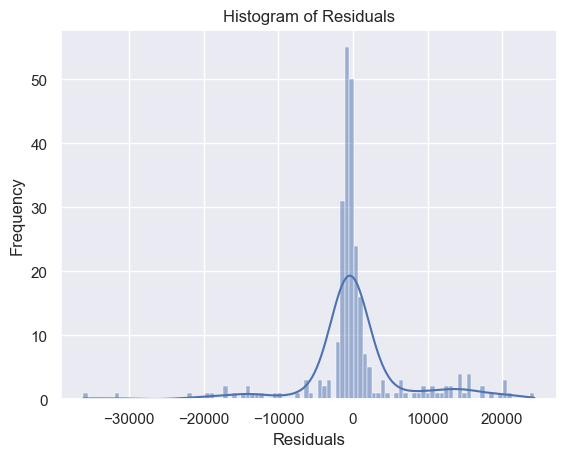

In [79]:
# Normality check histogram
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

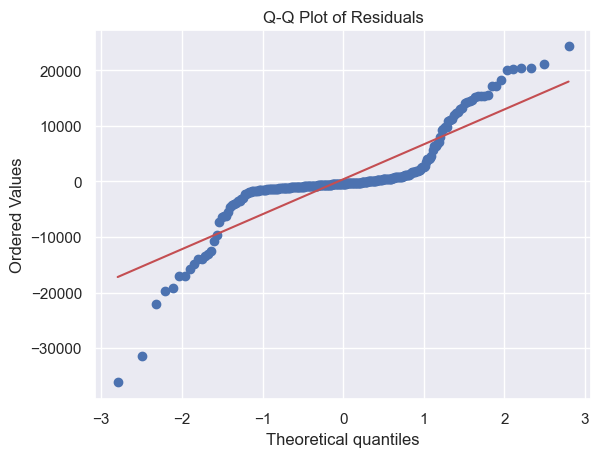

In [80]:
# Q-Q plot normality check
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

# Model interpretation using shap

In [81]:
explainer = shap.LinearExplainer(model, x_train)


In [82]:
shap_values = explainer.shap_values(x_test)


In [83]:
np.shape(shap_values)

(268, 11)

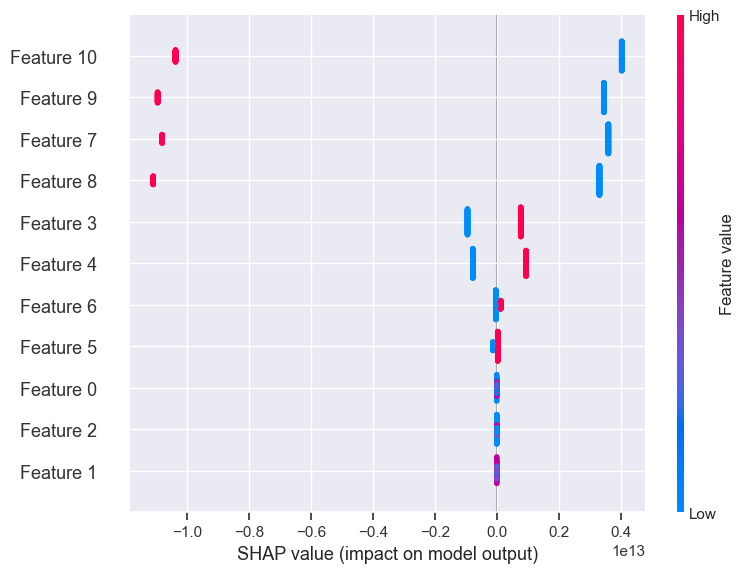

In [84]:
shap.summary_plot(shap_values, x_test)
